# Predicting Check-ins of Foursquare Users in Tokyo

## 4 - Machine Learning

### Import libraries

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import label_binarize

import matplotlib.pyplot as plt
import matplotlib
from matplotlib import rcParams
import seaborn as sns

In [2]:
sns.set_style("whitegrid")
sns.set_context("poster")
rcParams['figure.figsize'] = (12.5, 11)
rcParams['figure.dpi'] = 250
rcParams['font.size'] = 12

### Load engineered features

In [3]:
df = pd.read_csv('df_afterwrangling.csv',
                 index_col=0,
                 parse_dates=[0],
                 date_parser=pd.to_datetime,
                 infer_datetime_format=True)

In [4]:
df_creatures_of_habit = pd.read_csv('df_creatures_of_habit.csv',
                                    index_col=0,
                                    parse_dates=[0],
                                    date_parser=pd.to_datetime,
                                    infer_datetime_format=True
                                    )
df_irregular_creatures_of_habit = pd.read_csv('df_irregular_creatures_of_habit.csv',
                                              index_col=0,
                                              parse_dates=[0],
                                              date_parser=pd.to_datetime,
                                              infer_datetime_format=True
                                              )

In [5]:
df_creatures_of_habit.tail()

,userid_time_place_0,userid_time_place_1,userid_time_place_2,userid_time_place_3,userid_time_place_4,userid_time_place_5,userid_time_place_6,userid_time_place_7,userid_time_place_8,userid_time_place_9,userid_time_place_10,userid_time_place_11,userid_time_place_12,userid_time_place_13,userid_time_place_14,userid_time_place_15,userid_time_place_16,userid_time_place_17,userid_time_place_18,userid_time_place_19,userid_time_place_20,userid_time_place_21,userid_time_place_22,userid_time_place_23,userid_time_place_24,userid_time_place_25,userid_time_place_26,userid_time_place_27,userid_time_place_28,userid_time_place_29,userid_time_place_30,userid_time_place_31,userid_time_place_32,userid_time_place_33,userid_time_place_34,userid_time_place_35,userid_time_place_36,userid_time_place_37,userid_time_place_38,userid_time_place_39,...,userid_time_place_207,userid_time_place_208,userid_time_place_209,userid_time_place_210,userid_time_place_211,userid_time_place_212,userid_time_place_213,userid_time_place_214,userid_time_place_215,userid_time_place_216,userid_time_place_217,userid_time_place_218,userid_time_place_219,userid_time_place_220,userid_time_place_221,userid_time_place_222,userid_time_place_223,userid_time_place_224,userid_time_place_225,userid_time_place_226,userid_time_place_227,userid_time_place_228,userid_time_place_229,userid_time_place_230,userid_time_place_231,userid_time_place_232,userid_time_place_233,userid_time_place_234,userid_time_place_235,userid_time_place_236,userid_time_place_237,userid_time_place_238,userid_time_place_239,userid_time_place_240,userid_time_place_241,userid_time_place_242,userid_time_place_243,userid_time_place_244,userid_time_place_245,userid_time_place_246
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-02-16 11:34:35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-16 11:34:53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-16 11:34:55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-16 11:35:17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-16 11:35:29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
df_irregular_creatures_of_habit.tail()

,userid_place_0,userid_place_1,userid_place_2,userid_place_3,userid_place_4,userid_place_5,userid_place_6,userid_place_7,userid_place_8,userid_place_9,userid_place_10,userid_place_11,userid_place_12,userid_place_13,userid_place_14,userid_place_15,userid_place_16,userid_place_17,userid_place_18,userid_place_19,userid_place_20,userid_place_21,userid_place_22,userid_place_23,userid_place_24,userid_place_25,userid_place_26,userid_place_27,userid_place_28,userid_place_29,userid_place_30,userid_place_31,userid_place_32,userid_place_33,userid_place_34,userid_place_35,userid_place_36,userid_place_37,userid_place_38,userid_place_39,...,userid_place_207,userid_place_208,userid_place_209,userid_place_210,userid_place_211,userid_place_212,userid_place_213,userid_place_214,userid_place_215,userid_place_216,userid_place_217,userid_place_218,userid_place_219,userid_place_220,userid_place_221,userid_place_222,userid_place_223,userid_place_224,userid_place_225,userid_place_226,userid_place_227,userid_place_228,userid_place_229,userid_place_230,userid_place_231,userid_place_232,userid_place_233,userid_place_234,userid_place_235,userid_place_236,userid_place_237,userid_place_238,userid_place_239,userid_place_240,userid_place_241,userid_place_242,userid_place_243,userid_place_244,userid_place_245,userid_place_246
timestamp,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2013-02-16 11:34:35,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-16 11:34:53,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-16 11:34:55,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-16 11:35:17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-02-16 11:35:29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Concatenate all features into one DataFrame

In [7]:
df_ML = pd.concat(
    [df_creatures_of_habit, df_irregular_creatures_of_habit], axis=1)

### Perform Logistic Regression with hyperparameter tuning

In [8]:
Xtrain = df_ML['2012-July':'2013-Jan']
Xtest = df_ML['2013-Feb':]
ytrain = df['2012-July':'2013-Jan'].venuecat_encoded
ytest = df['2013-Feb':].venuecat_encoded

In [9]:
C_range = [0.01, 0.1, 1]
tscv = TimeSeriesSplit()
train_acc_dict = {}
test_acc_dict = {}

for C in C_range:
    
    C_train_acc = []
    C_test_acc = []
    
    for train_index, test_index in tscv.split(Xtrain):

        clf = LogisticRegression(C=C, max_iter=500)
        clf.fit(Xtrain.values[train_index], ytrain.values[train_index])
        ytrain_split = clf.predict(Xtrain.values[train_index])
        ytest_split = clf.predict(Xtrain.values[test_index])
    
        C_train_acc.append(accuracy_score(ytrain.values[train_index], ytrain_split))
        C_test_acc.append(accuracy_score(ytrain.values[test_index], ytest_split))
        
    train_acc_dict[C] = np.mean(C_train_acc)
    test_acc_dict[C] = np.mean(C_test_acc)

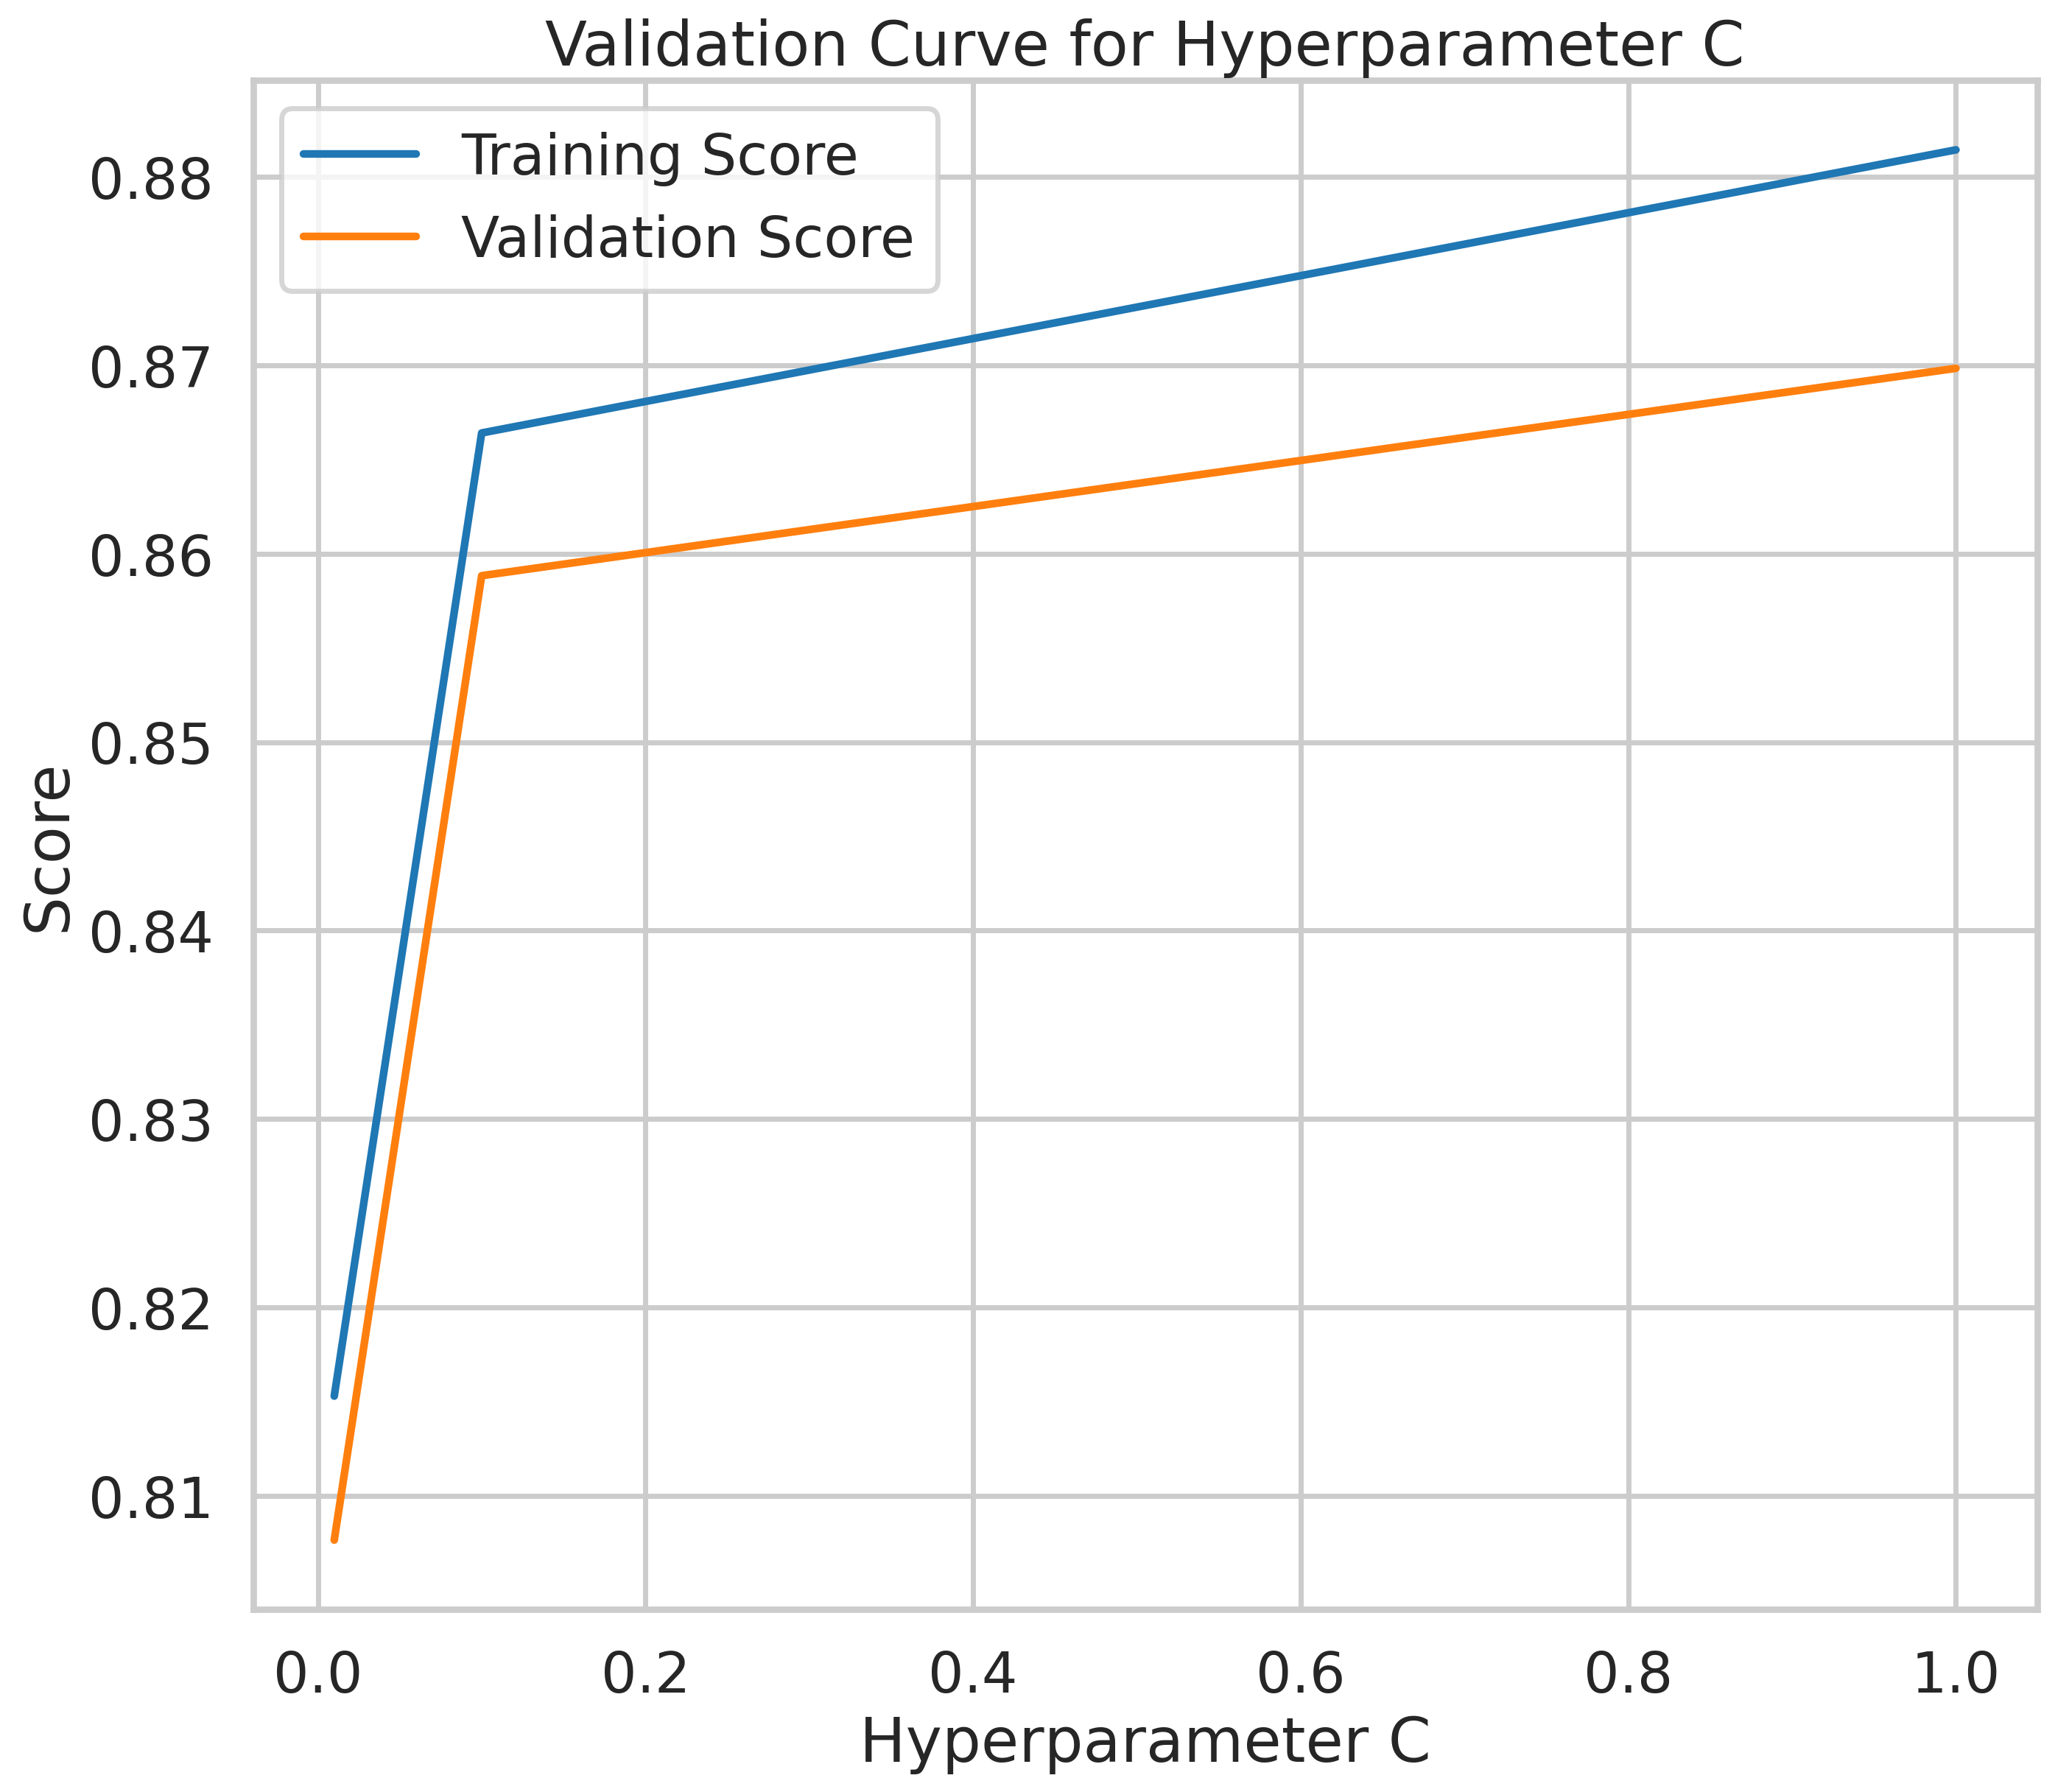

In [10]:
C_train_tuple = sorted(train_acc_dict.items())
C_test_tuple = sorted(test_acc_dict.items())

C_train, train_acc = zip(*C_train_tuple)
C_test, test_acc = zip(*C_test_tuple)

plt.plot(C_train, train_acc)
plt.plot(C_test, test_acc)

plt.xlabel("Hyperparameter C")
plt.ylabel("Score")
plt.legend(["Training Score", "Validation Score"])
plt.title("Validation Curve for Hyperparameter C");

In [11]:
acc_diffs = [train - test for train, test in zip(train_acc, test_acc)]
best_fit = min(
    [train - test for train, test in zip(train_acc, test_acc) if train > test])
C_best = C_range[acc_diffs.index(best_fit)]

In [12]:
clf = LogisticRegression(C=C_best, max_iter=500)
clf.fit(Xtrain, ytrain)
ytrain_pred = clf.predict(Xtrain)
ytest_pred = clf.predict(Xtest)
ytest_probs = clf.predict_proba(Xtest)

### Evaluate model performance

In [13]:
print("Train Accuracy: {0:.2f}%".format(
    accuracy_score(ytrain, ytrain_pred) * 100))
print("Test Accuracy: {0:.2f}%".format(
    accuracy_score(ytest, ytest_pred) * 100))
print("F1 score: {0:.2f}".format(f1_score(ytest, ytest_pred, average='micro')))

Train Accuracy: 86.76%
Test Accuracy: 85.36%
F1 score: 0.85


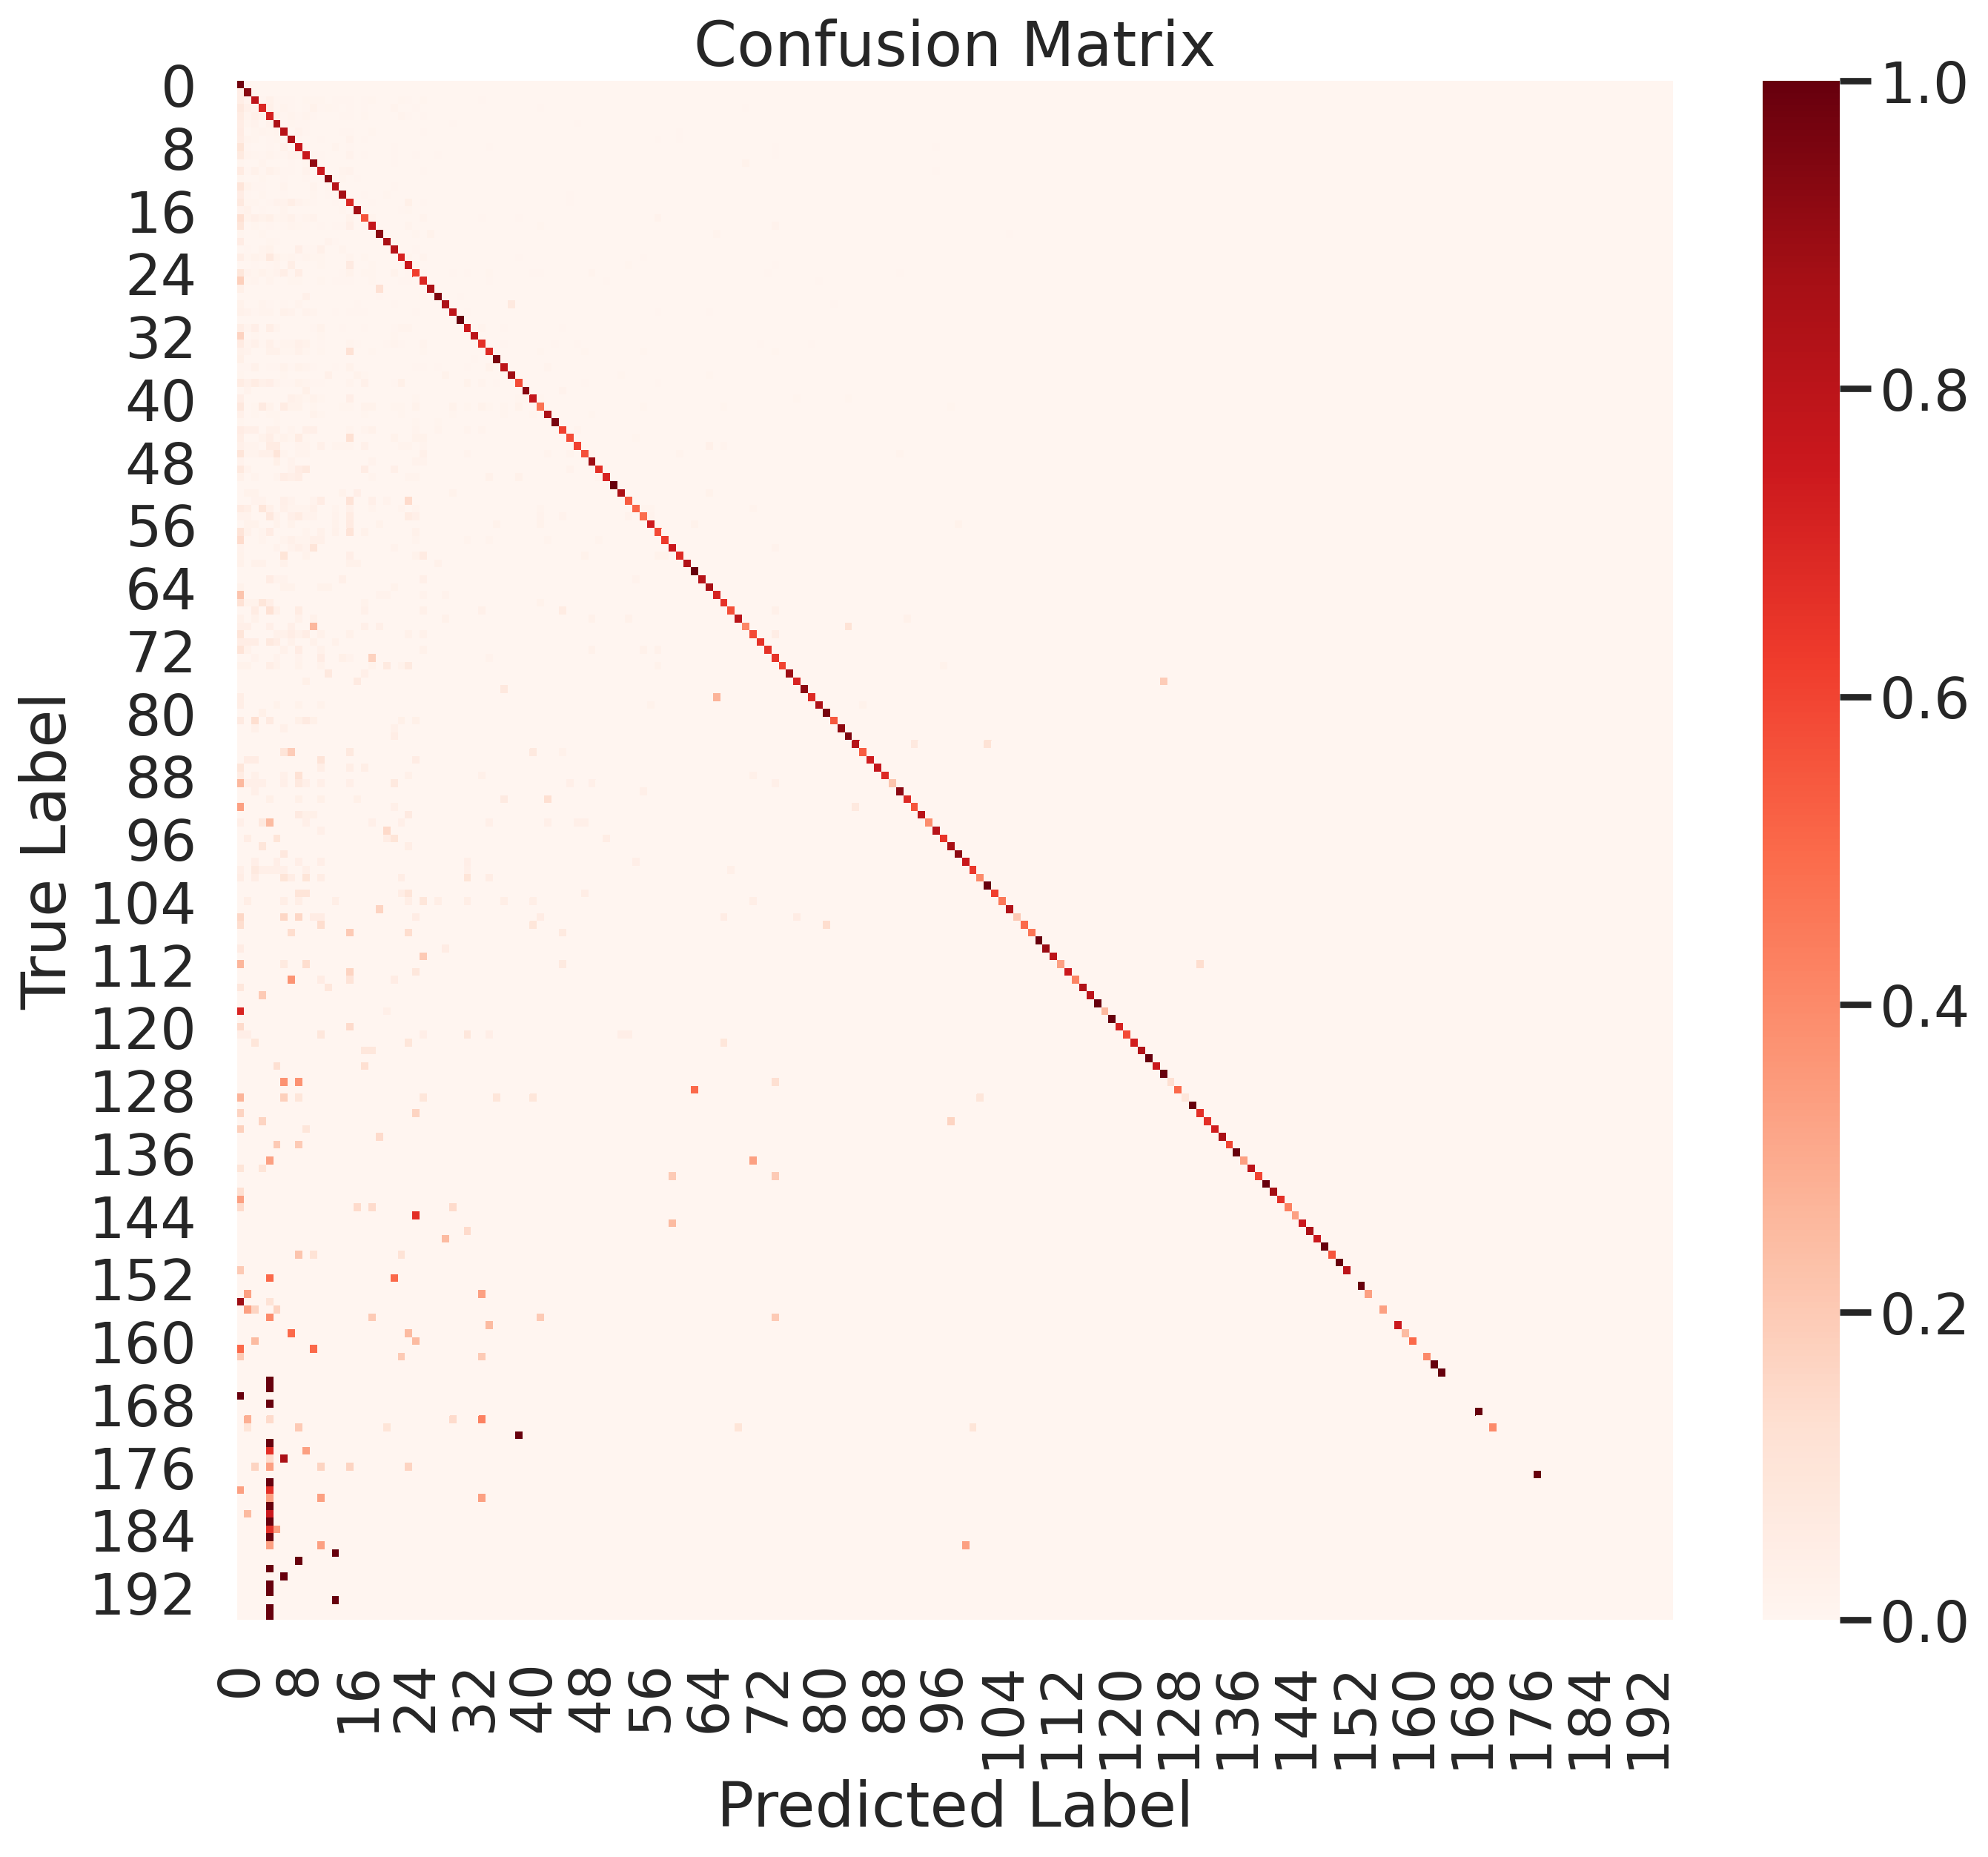

In [14]:
cm = confusion_matrix(ytest, ytest_pred, normalize='true')
sns.heatmap(cm, cmap='Reds')
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label");

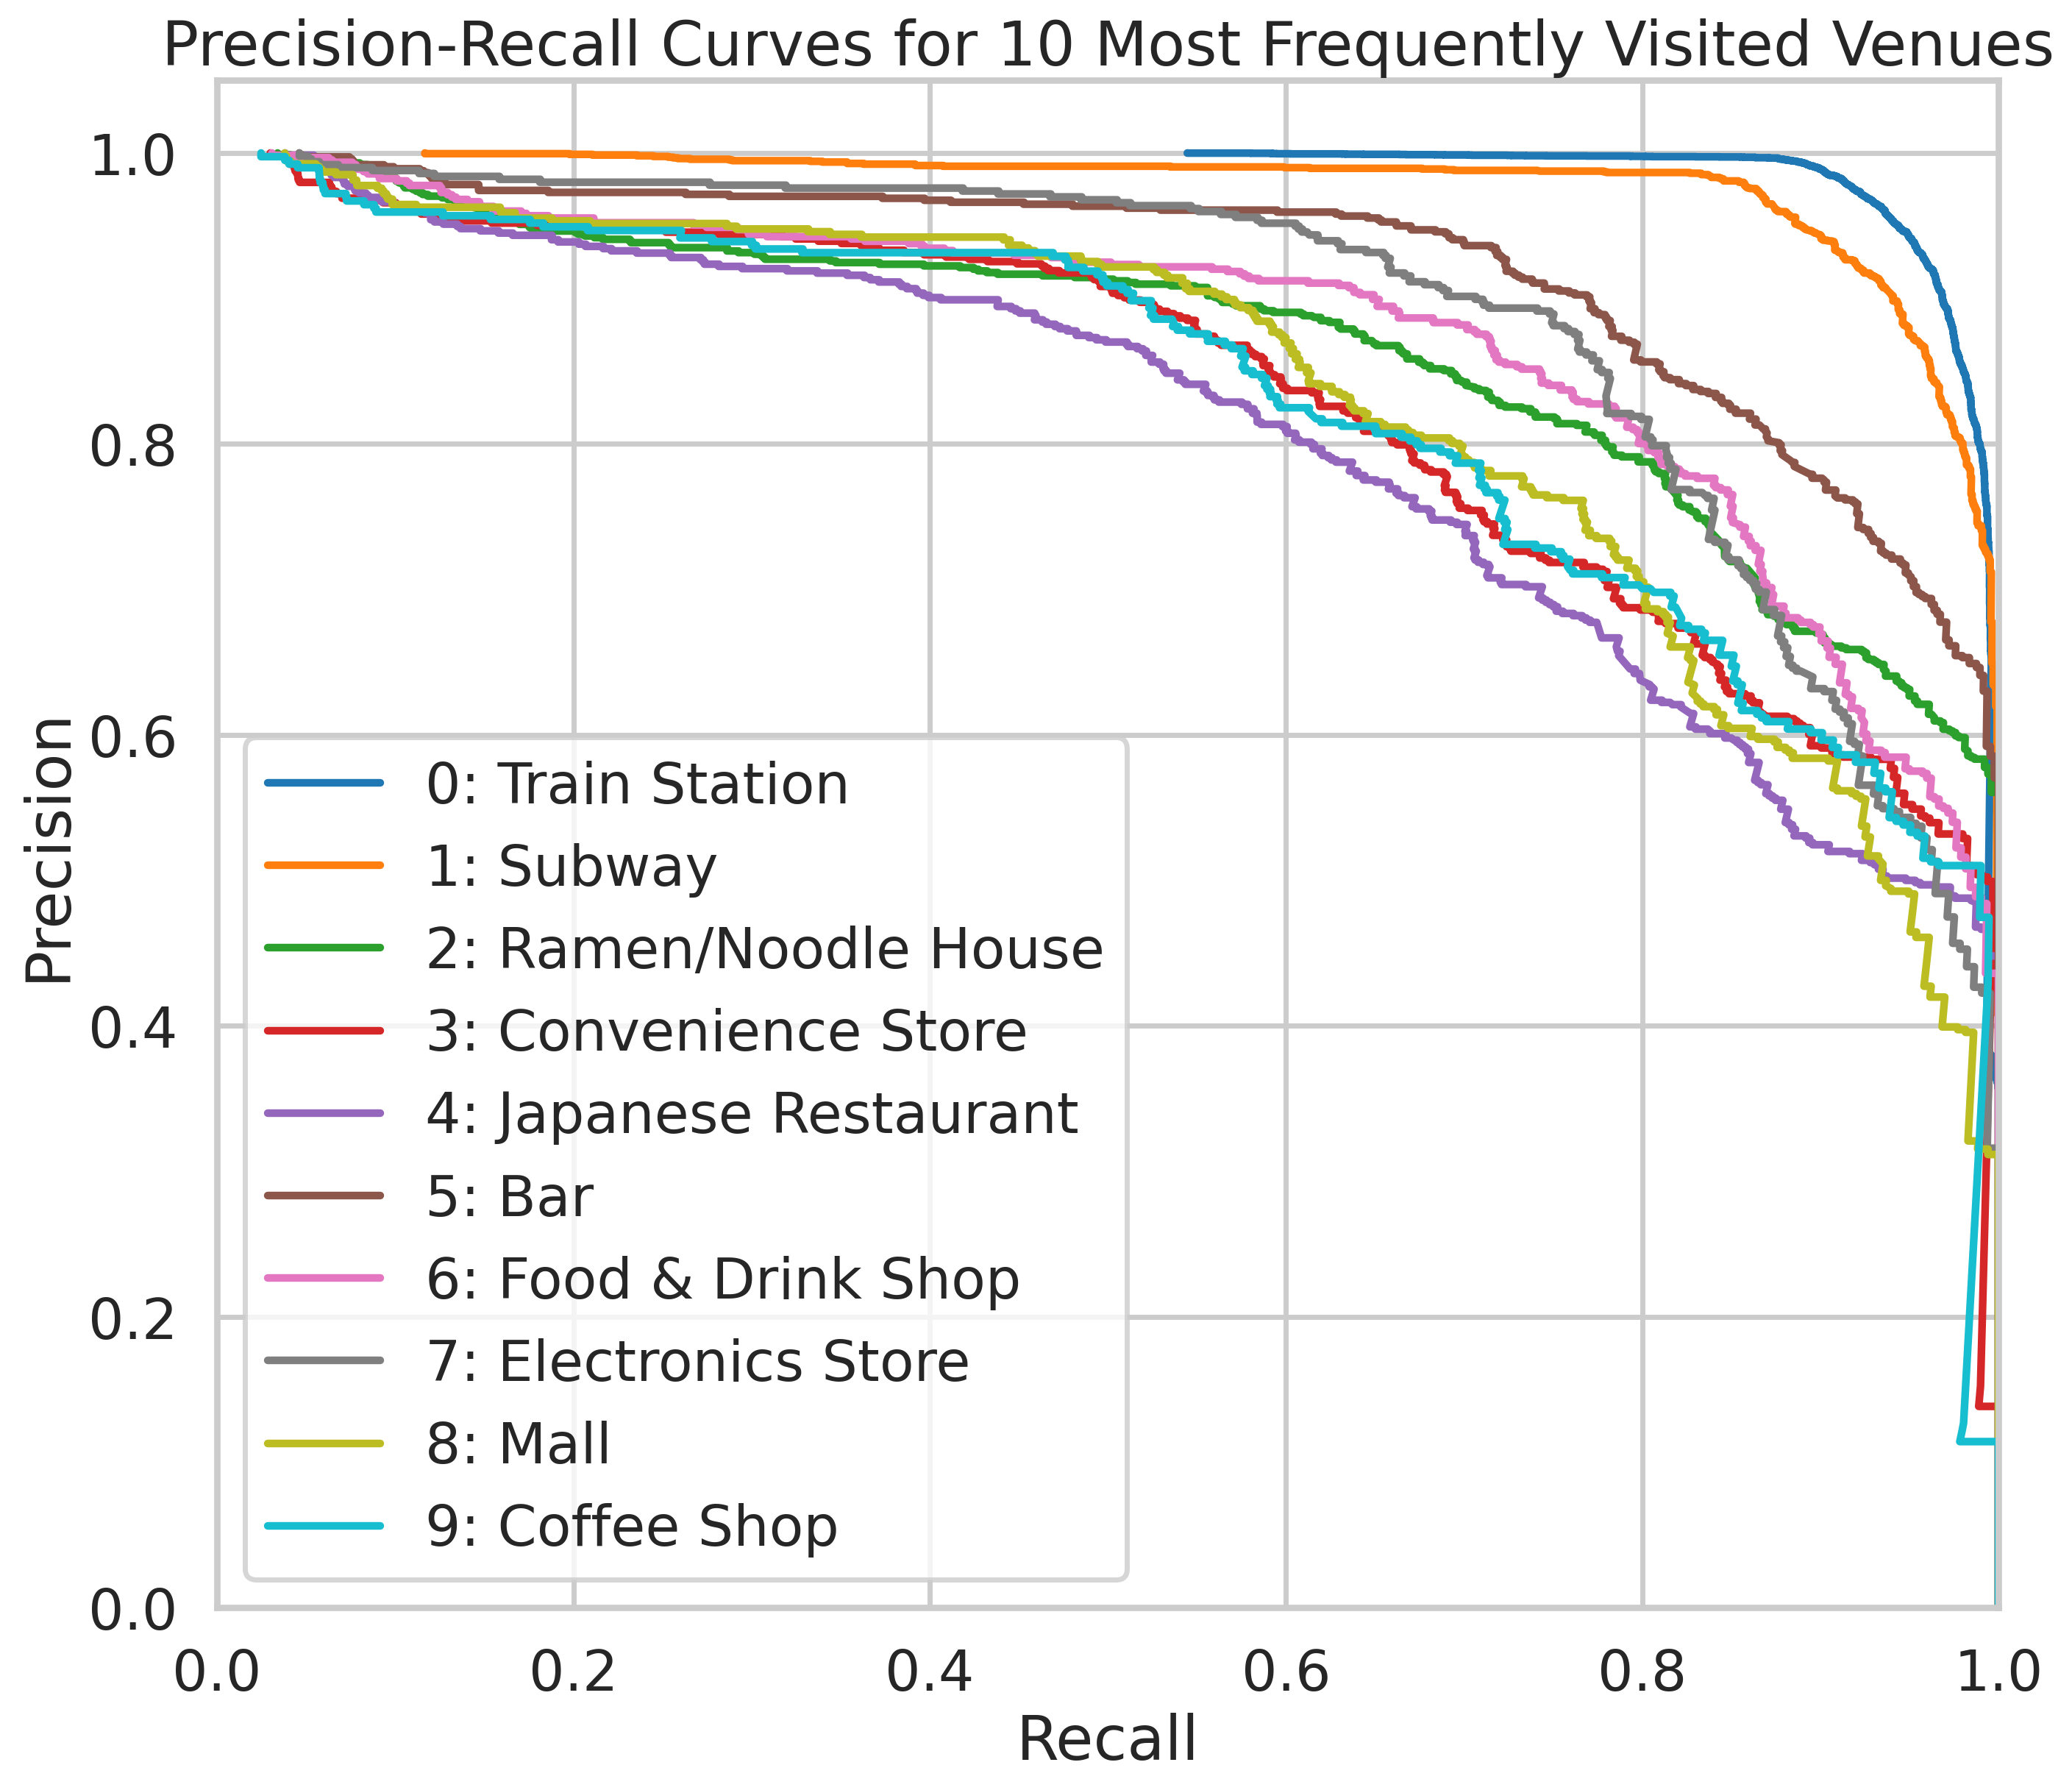

In [15]:
ytest_binarized = label_binarize(ytest.values, classes=range(247))

precision = dict()
recall = dict()

plt.figure()

for i in range(10):
    precision[i], recall[i], _ = precision_recall_curve(
        ytest_binarized[:, i], ytest_probs[:, i])
    plt.plot(precision[i], recall[i])

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.legend(["0: Train Station", "1: Subway", "2: Ramen/Noodle House",
            "3: Convenience Store", "4: Japanese Restaurant",
            "5: Bar", "6: Food & Drink Shop", "7: Electronics Store",
            "8: Mall", "9: Coffee Shop"])
plt.title("Precision-Recall Curves for 10 Most Frequently Visited Venues");